In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
pd.set_option('display.max_columns', None)

## Preparacion de los datos

In [3]:
dataDir='data'
resultsDir='results'

if not os.path.exists(resultsDir):
    os.mkdir(resultsDir)

Descripcion de las columnas

- Review: Comentarios escritos por usuarios de IMDB acerca de peliculas. (https://www.imdb.com/)
- Sentiment: Valoracion de la pelicula. El valor 1 significa positiva, mientras que 0 es negativa


In [4]:
dataFile='Reviews peliculas IMDB small.txt'
dataFile=os.path.join(dataDir, dataFile)

colNames = ['Review', 'Sentiment']

dataDF=pd.read_csv(dataFile, sep = '\t', header = None)
dataDF.columns = colNames

dataDF.head()

,Review,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [5]:
len(dataDF)

748

In [6]:
dataDF['Sentiment'].value_counts()

1    386
0    362
Name: Sentiment, dtype: int64

In [7]:
dataDF.isnull().sum()

Review       0
Sentiment    0
dtype: int64

## Procesamiento de lenguaje natural

In [8]:
import string
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

In [9]:
nlp = spacy.load('en_core_web_sm')
sent = nlp.create_pipe('sentencizer')

stopwordsNLP = list(STOP_WORDS)
punctuationNLP = string.punctuation

In [10]:
text = dataDF.sample(3)['Review'].values[0]
doc = nlp(text)

print(text, '\n')
for token in doc:
    print(token.text, token.pos_)

But I thought his acting was skilled.   

But CCONJ
I PRON
thought VERB
his DET
acting NOUN
was AUX
skilled ADJ
. PUNCT
  SPACE


In [11]:
displacy.render(doc, style = 'dep')

In [12]:
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwordsNLP and token not in punctuationNLP:
            cleaned_tokens.append(token)
    return cleaned_tokens


In [13]:
text_data_cleaning(text)

['think', 'acting', 'skilled']

## Vectorization Feature Engineering (TF-IDF)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC

In [15]:
X = dataDF['Review']
y = dataDF['Sentiment']

In [16]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [17]:
XTrain.shape, XTest.shape

((598,), (150,))

In [18]:
yTrain.value_counts()

1    309
0    289
Name: Sentiment, dtype: int64

In [19]:
tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)
classifier = LinearSVC()

In [20]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)], verbose=True)

We train the model

In [21]:
clf.fit(XTrain, yTrain)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   4.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x0000029757F381F8>)),
                ('clf', LinearSVC())],
         verbose=True)

In [22]:
yPred = clf.predict(XTest)

print(yPred[0:10])
print(yTest[0:10].values)

[1 0 0 1 0 0 0 0 1 0]
[1 1 0 1 0 0 0 0 1 1]


In [23]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          figFile='model_confussion_matrix.jpg'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.tick_params(labelbottom=False, labeltop=True, labelright=False, )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    fig.tight_layout()
    
    figFile = os.path.join(resultsDir, figFile)
    fig.savefig(figFile, dpi=300)

Confusion matrix, without normalization


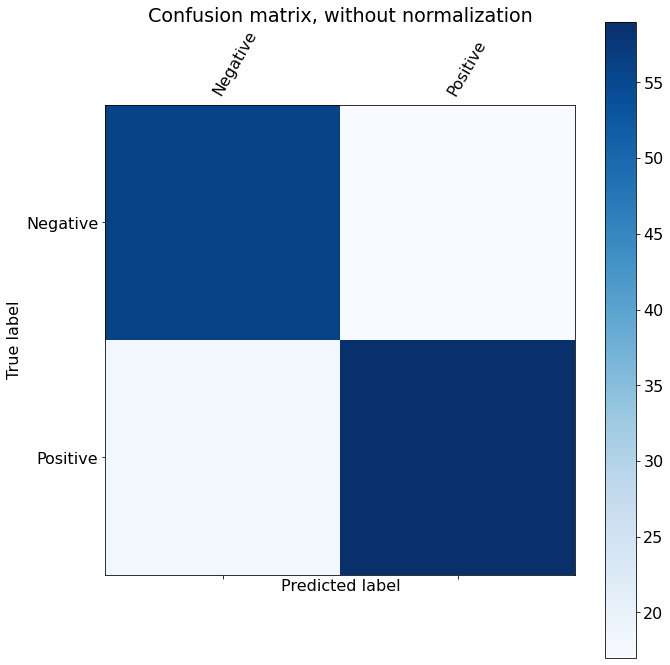

In [24]:
labels = ['Negative', 'Positive']
cm = confusion_matrix(yTest, yPred, labels=[0, 1])

plot_confusion_matrix(yTest, yPred, labels)

In [25]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76        73
           1       0.78      0.77      0.77        77

    accuracy                           0.77       150
   macro avg       0.77      0.77      0.77       150
weighted avg       0.77      0.77      0.77       150

